# 01 Data Cleaning and Initial EDA

## 1. Import Libraries

In [2]:
import pandas as pd 
import numpy as np
import re
import json

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 2. Data Cleaning

### 2.1 Create Function for Cleaning

Create function to clean both comments from Omega and Cartier subforum.  
This is an iterative process, after EDA we go back to clean again.  
We also do sample for Omega number of comments to make it closer to Cartier number of comments.

In [3]:
# Create function for cleaning
def cleaning_json(json_file, tokenizer = RegexpTokenizer(r'\w+'), stop_words=True, lemmatizer = WordNetLemmatizer(), 
                  words_to_remove = ['http', 'www', 'com', 'watchuseek', 'tapatalk', 'iphone', 'using', 'samsung', 'emoji769', 'expand', '8230', 'g930f', 'would', 'like', 'view'],
                  omega=0):

    # Import json file as totalcomments
    with open(json_file,'r') as f:
        json_data = json.load(f)
    
    # Extract comments only
    comments = [i['body'] for i in json_data]
    
    # Tokenizing
    if tokenizer:
        comments_tokens = [tokenizer.tokenize(i.lower()) for i in comments]
        comments = comments_tokens
    
    # Remove stop words
    if stop_words:
        comments_no_stop_words = []
        for comment in comments:
            comment_no_stop_words = [token for token in comment if token not in stopwords.words('english')]
            comments_no_stop_words.append(comment_no_stop_words)  
        comments = comments_no_stop_words
            
    # Lemmatizing
    if lemmatizer:
        comments_lemmatized = []
        for comment in comments:
            comment_lemmatized = [lemmatizer.lemmatize(i) for i in comment]
            comments_lemmatized.append(comment_lemmatized)
        comments = comments_lemmatized
        
    # Remove additional words
    if words_to_remove:
        comments_cleaned = []
        for comment in comments:
            comment_cleaned = []
            for word in comment:
                if word not in words_to_remove:
                    comment_cleaned.append(word)
            comments_cleaned.append(comment_cleaned)
        comments = comments_cleaned
    
    # Combine comments after additional cleaning
    combined_comments = [' '.join(comment) for comment in comments]
    combined_comments
    
    # Convert DF
    df = pd.DataFrame(combined_comments)
    df.rename(columns={0:'comments'}, inplace=True)

    # Add omega cat column
    if omega == 0:
        df['omega'] = 0
    else:
        df['omega'] = 1
        
    # Replace empty and null to NaN
    df.replace(['', 'null'], np.nan, inplace=True)
    # Drop NaN
    df = df.dropna()
    
    # Limit df to 15,000 rows
    if df.shape[0] > 15000:
        df = df.sample(n=15000, random_state=42)
    
    return df

### 2.2 Clean Omega Data

In [3]:
# # Clean Cartier json to df
# omega_df = cleaning_json('../datasets/omega.json', omega=1)

In [6]:
# # Export Omega df to csv
# omega_df.to_csv('../datasets/omega.csv', index=False)

Omega data is already cleaned and exported from above code. So we will use read_csv() to save time

In [4]:
omega_df = pd.read_csv('../datasets/omega.csv')

In [8]:
omega_df.head()

,comments,omega
0,reference 2531 80 ask service history thanks,1
1,little know reference think inclined reissue s...,1
2,love railmaster,1
3,seven watch need seven watch first make one wa...,1
4,go omega tudor hour hand also though say dated...,1


In [5]:
omega_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  15000 non-null  object
 1   omega     15000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.5+ KB


### 2.3 Clean Cartier Data

In [7]:
# # Clean Cartier json to df
# cartier_df = cleaning_json('../datasets/cartier.json')

In [9]:
# # Export Cartier df to csv
# cartier_df.to_csv('../datasets/cartier.csv', index=False)

Cartier data is already cleaned and exported from above code. So we will use read_csv() to save time

In [9]:
cartier_df = pd.read_csv('../datasets/cartier.csv')

In [10]:
cartier_df.head()

,comments,omega
0,proud honored introduce new cartier forum stro...,0
1,glad opened forum,0
2,yay glad see powerhouse getting subforum reall...,0
3,step 1 cartier forum step 2 cartier wrist step...,0
4,thanks joined forum getting first real watch r...,0


In [11]:
cartier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14328 entries, 0 to 14327
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  14328 non-null  object
 1   omega     14328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 224.0+ KB


## 3. EDA

### 3.1. Omega EDA

In [12]:
X_omega = omega_df['comments']
y_omega = omega_df['omega']

#### 3.1.1. 1 Gram

In [13]:
# Initiate cvec
cvec_omega_1 = CountVectorizer()

In [14]:
# Fit
cvec_omega_1.fit(X_omega)

CountVectorizer()

In [15]:
X_omega_1 = cvec_omega_1.transform(X_omega)

In [16]:
X_omega_1

<15000x20703 sparse matrix of type '<class 'numpy.int64'>'
	with 319231 stored elements in Compressed Sparse Row format>

In [17]:
X_omega_1.shape

(15000, 20703)

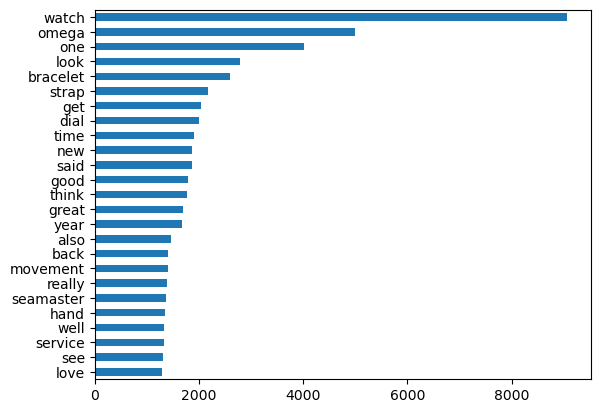

In [18]:
# convert training data to dataframe
X_omega_1_df = pd.DataFrame(X_omega_1.todense(), 
                          columns=cvec_omega_1.get_feature_names_out())

# plot top occuring words
X_omega_1_df.sum().sort_values(ascending=True).tail(25).plot(kind='barh');

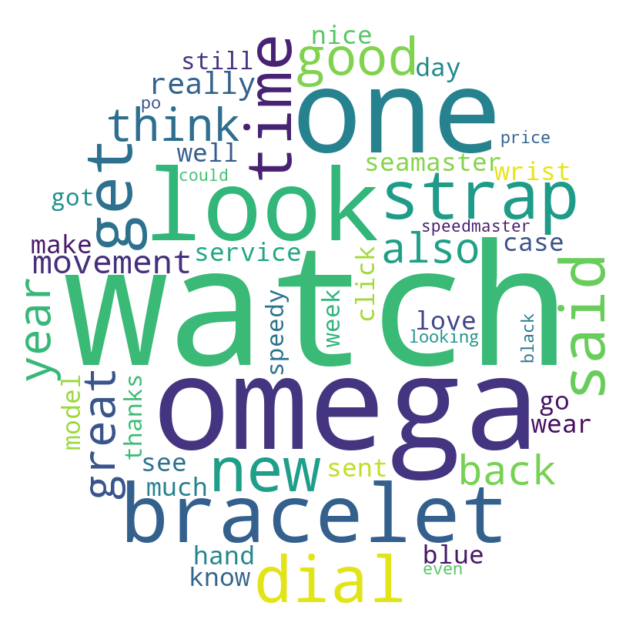

In [19]:
top_100_omega_1 = X_omega_1_df.sum().sort_values(ascending=False).head(50).to_dict()

# Create a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      mask=mask).generate_from_frequencies(top_100_omega_1)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### 3.1.2. 2 Gram

In [20]:
# Initiate cvec
cvec_omega_2 = CountVectorizer(ngram_range=(2,2))

In [21]:
# Fit
cvec_omega_2.fit(X_omega)

CountVectorizer(ngram_range=(2, 2))

In [22]:
X_omega_2 = cvec_omega_2.transform(X_omega)
X_omega_2

<15000x223979 sparse matrix of type '<class 'numpy.int64'>'
	with 352737 stored elements in Compressed Sparse Row format>

In [23]:
# convert training data to dataframe
X_omega_2_df = pd.DataFrame(X_omega_2.todense(), columns=cvec_omega_2.get_feature_names_out())

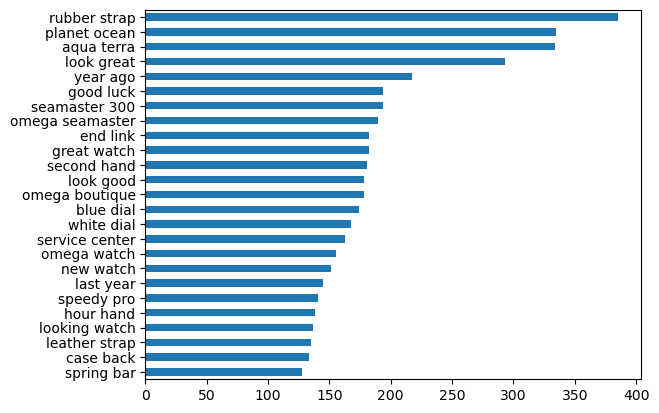

In [24]:
# plot top occuring words
X_omega_2_df.sum().sort_values(ascending=True).tail(25).plot(kind='barh');

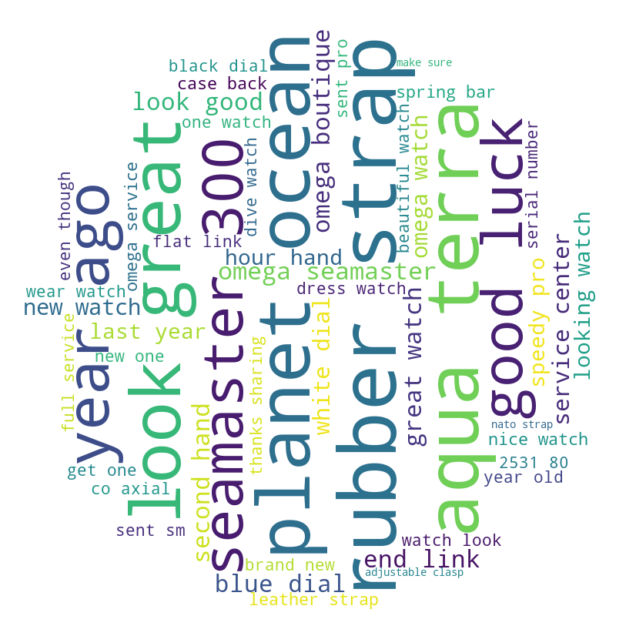

In [25]:
top_100_omega_2 = X_omega_2_df.sum().sort_values(ascending=False).head(50).to_dict()

# Create a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      mask=mask).generate_from_frequencies(top_100_omega_2)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 3.2. Cartier EDA

In [26]:
X_cartier = cartier_df['comments']
y_cartier = cartier_df['omega']

#### 3.2.1. 1 Gram

In [27]:
# Initiate cvec
cvec_cartier_1 = CountVectorizer()

In [28]:
# Fit
cvec_cartier_1.fit(X_cartier)

CountVectorizer()

In [29]:
X_cartier_1 = cvec_cartier_1.transform(X_cartier)

In [30]:
X_cartier_1

<14328x17330 sparse matrix of type '<class 'numpy.int64'>'
	with 293818 stored elements in Compressed Sparse Row format>

In [31]:
X_cartier_1.shape

(14328, 17330)

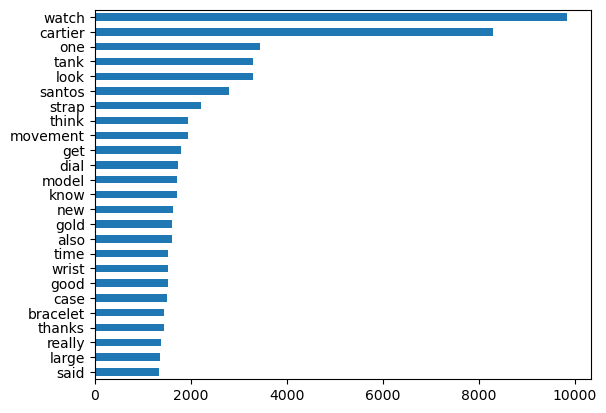

In [32]:
# convert training data to dataframe
X_cartier_1_df = pd.DataFrame(X_cartier_1.todense(), 
                          columns=cvec_cartier_1.get_feature_names_out())

# plot top occuring words
X_cartier_1_df.sum().sort_values(ascending=True).tail(25).plot(kind='barh');

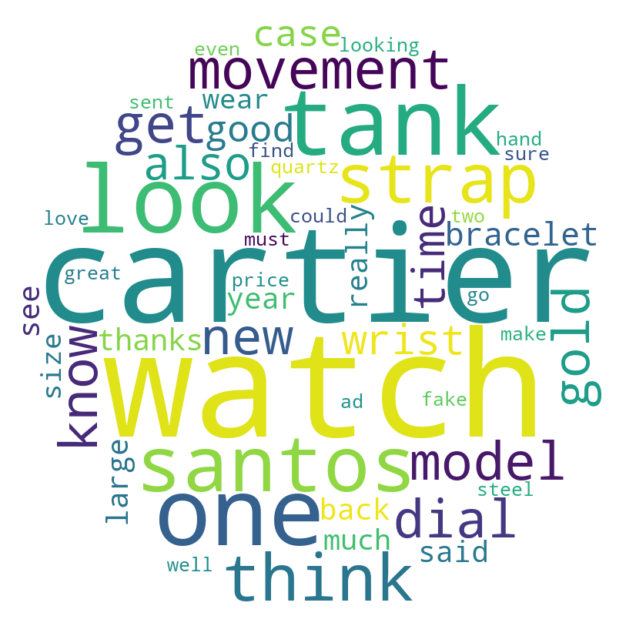

In [33]:
top_100_cartier_1 = X_cartier_1_df.sum().sort_values(ascending=False).head(50).to_dict()

# Create a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      mask=mask).generate_from_frequencies(top_100_cartier_1)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### 3.2.2. 2 Gram

In [34]:
# Initiate cvec
cvec_cartier_2 = CountVectorizer(ngram_range=(2,2))

In [35]:
# Fit
cvec_cartier_2.fit(X_cartier)

CountVectorizer(ngram_range=(2, 2))

In [36]:
X_cartier_2 = cvec_cartier_2.transform(X_cartier)
X_cartier_2

<14328x187249 sparse matrix of type '<class 'numpy.int64'>'
	with 326209 stored elements in Compressed Sparse Row format>

In [37]:
X_cartier_2.shape

(14328, 187249)

In [38]:
# convert training data to dataframe
X_cartier_2_df = pd.DataFrame(X_cartier_2.todense(), columns=cvec_cartier_2.get_feature_names_out())

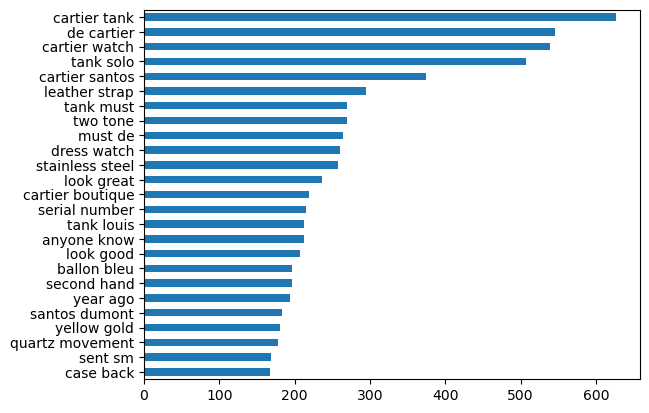

In [39]:
# plot top occuring words
X_cartier_2_df.sum().sort_values(ascending=True).tail(25).plot(kind='barh');

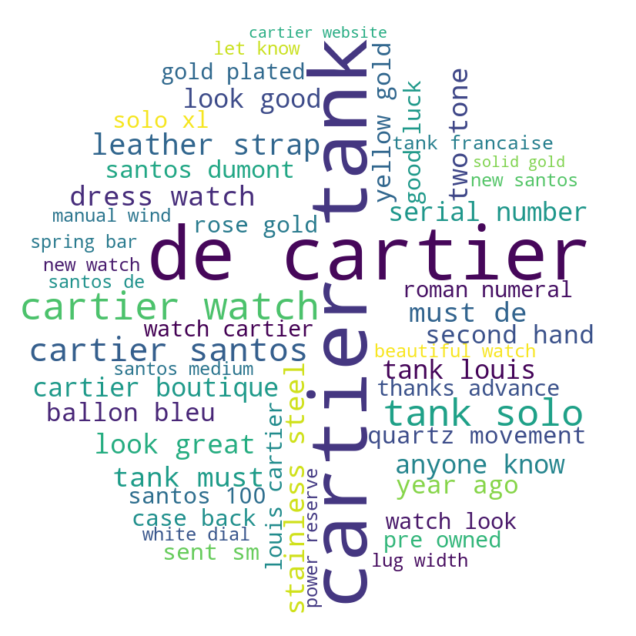

In [40]:
top_100_cartier_2 = X_cartier_2_df.sum().sort_values(ascending=False).head(50).to_dict()

# Create a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      mask=mask).generate_from_frequencies(top_100_cartier_2)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that Cartier community talks more about Cartier products compared to Omega community talks about Omega product.

We will have additional more in depth EDA in the next notebook.